# full explanation : https://www.notion.so/Analysis-Sentimen-pada-Game-Let-s-GetRich-2fd659dff8b380688418ce50ce1fadf9?source=copy_link

# Import Library and Modul

In [ ]:
!pip install langid

In [ ]:
pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import langid
import re
import string
import nltk
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import torch
import keras_tuner as kt

from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [ ]:
nltk.download('punkt_tab')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 1. Load Data dan Validasi data

In [ ]:
url = "https://raw.githubusercontent.com/asepsr37/data-and-machine-learning/main/sentiment-analysis/lets-get-rich/1-scraping/hasil_scraping_data_lgr.csv"
data_lgr = pd.read_csv(url)
data_lgr

,User,Review,Rating,Date
0,A Google user,"wow, a very PAY-TO-WIN game, never seen such g...",1,2026-01-29 15:22:39
1,A Google user,Hahaha 2 times. I can't login with my Line acc...,1,2026-01-30 14:17:07
2,A Google user,"absolute trash, glad I stop since ejeab & io c...",1,2026-01-14 14:02:02
3,A Google user,This game is fun and all if you have the chara...,1,2025-09-29 13:11:16
4,A Google user,Absolutely garbage pay-to-win game. Special ch...,1,2022-01-10 08:08:17
...,...,...,...,...
122179,A Google user,NaN,1,2015-10-21 14:16:08
122180,A Google user,NaN,1,2015-01-05 23:47:31
122181,A Google user,NaN,1,2015-04-08 16:05:04
122182,A Google user,NaN,2,2015-08-07 19:05:00


In [ ]:
# struktur data
data_lgr.shape

(122184, 4)

In [ ]:
# tipe data
data_lgr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122184 entries, 0 to 122183
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   User    122184 non-null  object
 1   Review  121945 non-null  object
 2   Rating  122184 non-null  int64 
 3   Date    122184 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.7+ MB


In [ ]:
# missing value
data_lgr.isnull().sum()

,0
User,0
Review,239
Rating,0
Date,0


In [ ]:
# duplicated
data_lgr.duplicated().sum()

np.int64(0)

# 2. Data Preprocessing

In [ ]:
# salin data untuk keperluan preprocessing
data_lgr_cleaning = data_lgr.copy()

In [ ]:
# 1. Menghapus Missing Value
data_lgr_cleaning = data_lgr_cleaning.dropna()
# cek mv
print(data_lgr_cleaning.isnull().sum())

User      0
Review    0
Rating    0
Date      0
dtype: int64


In [ ]:
# 2. Saring kata, akan menggunakan kata berbahasa inggris saja
def is_english(text):
    if not text:
        return False
    lang, _ = langid.classify(text)
    return lang == 'en'
# Apply fungsi menyaring kata bahasa inggris
english_reviews = data_lgr_cleaning[data_lgr_cleaning['Review'].apply(is_english)]

In [ ]:
# 3. Bersihkan teks dari angka, simbol, link, emoji, dan sebagainya lalu buat huruf semuanya jadi kecil

# Fungsi untuk membersihkan text dari angka, simbol, link, dan lain-lain
def cleaningtext(review):
  review = re.sub(r"@[A-Za-z0-9]+", "", review)
  review = re.sub(r"#[A-Za-z0-9]+", "", review)
  review = re. sub(r"RT[\s]", "", review)
  review = re.sub(r"http\S+", "", review)
  review = re.sub(r"[0-9]+", "", review)
  review = re.sub(r"[^\w\s]", "", review)
  review = review.replace("\n", " ")
  review = review.translate(str.maketrans("", "", string.punctuation))
  review = review.strip(" ")
  return review

# Fungsi untuk mengbuah huruf menjadi keci
def casefolding(review):
  review = review.lower()
  return review

# Apply
english_reviews["review_clean"] = english_reviews["Review"].apply(cleaningtext)
english_reviews["review_casefolding"] = english_reviews["review_clean"].apply(casefolding)


/tmp/ipython-input-2258169436.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews["review_clean"] = english_reviews["Review"].apply(cleaningtext)
/tmp/ipython-input-2258169436.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews["review_casefolding"] = english_reviews["review_clean"].apply(casefolding)


In [ ]:
# 4. Mengubah nilai kosonng menjadi NaN
english_reviews['review_casefolding'] = english_reviews['review_casefolding'].replace(r'^\s*$', np.nan, regex=True)
# Cek missing value
print("Jumlah missing value setelah cleaning:", english_reviews['review_casefolding'].isnull().sum())
# Hapus baris yang NaN tersebut
english_reviews.dropna(subset=['review_casefolding'], inplace=True)
# Reset index agar urut kembali
english_reviews.reset_index(drop=True, inplace=True)

print(f"Data bersih tersisa: {len(english_reviews)} baris.")

In [ ]:
# 5. tokenisasi
# membuat fungsi tokenisasi
def tokenizingtext(review):
  review = word_tokenize(review)
  return review
# apply
english_reviews["review_token"] = english_reviews["review_casefolding"].apply(tokenizingtext)

In [ ]:
# Cek apakah masih terdapat kalimat yang bukan bahasa inggris
non_en_words = {
    # 🇮🇩 Indonesia
    "tidak", "yang", "dan", "saya", "ini", "itu", "dengan", "untuk", "ada", "karena",

    # 🇹🇭 Thai (kata umum & partikel)
    "ไม่", "มาก", "ดี", "เลย", "นะ", "ค่ะ", "ครับ", "คือ", "ว่า", "ไป", "มา",
}


mask = english_reviews["review_token"].apply(
    lambda tokens: any(w in non_en_words for w in tokens)
)

english_reviews.loc[mask, ["Review", "review_token"]]


,Review,review_token
454,this game just for people with a very deep poc...,"[this, game, just, for, people, with, a, very,..."
569,This is so hard to keep up with card or pendan...,"[this, is, so, hard, to, keep, up, with, card,..."
1009,"To many character ini this game,, end each of ...","[to, many, character, ini, this, game, end, ea..."
1617,"I just installed it again, but why if we chang...","[i, just, installed, it, again, but, why, if, ..."
2109,"Can't login and the text ""Cek untuk update""","[cant, login, and, the, text, cek, untuk, update]"
...,...,...
90205,APA ini,"[apa, ini]"
91043,Ini bgs bgt,"[ini, bgs, bgt]"
91074,BAGUS DAN SERUH,"[bagus, dan, seruh]"
91079,Aqw suka ini,"[aqw, suka, ini]"


In [ ]:
# 6. Menghapus kalimat bahasa indonesia dan kalimat dengan mix bahasa
# kamus
english_vocab = set(w.lower() for w in words.words())
# Membuat fungsi untuk cek token berbahasa inggris
def english(tokens):
    if not tokens or not isinstance(tokens, list):
        return False
    tokens = [token for token in tokens if token.isalpha() and token.strip() != '']

    if not tokens:
        return False
    return all(token in english_vocab for token in tokens)
# apply
english_reviews2 = english_reviews[english_reviews['review_token'].apply(english)]

# Menghapus baris yang ada kata 'saya'
english_reviews2 = english_reviews2[
    ~english_reviews2["review_token"].apply(lambda tokens: "saya" in tokens)
]

In [ ]:
# 5. Stopwords

# Membuat Fungsi Stopwords
stop_words = set(stopwords.words('english'))
# Fungsinya
def remove_stopwords(tokens):
  return [token for token in tokens if token.lower() not in stop_words]
# apply
english_reviews2["review_stopwords"] = english_reviews2["review_token"].apply(remove_stopwords)

In [ ]:
# 6. Jadikan Kalimat

# Membuat fungsi menjadi kalimat
def toSentence(list_words):
  sentence = " ".join (word for word in list_words)
  return sentence
# apply
english_reviews2["review_final"]=english_reviews2["review_stopwords"].apply(toSentence)

In [ ]:
# 7. Mengubah nilai kosonng menjadi NaN
english_reviews2["review_final"] = english_reviews2["review_casefolding"].replace(r'^\s*$', np.nan, regex=True)
# Cek missing value
print("Jumlah missing value setelah cleaning:", english_reviews2["review_final"].isnull().sum())
# Hapus baris yang NaN tersebut
english_reviews2.dropna(subset=["review_final"], inplace=True)
# Reset index agar urut kembali
english_reviews2.reset_index(drop=True, inplace=True)

print(f"Data bersih tersisa: {len(english_reviews2)} baris.")

Jumlah missing value setelah cleaning: 0
Data bersih tersisa: 52503 baris.


In [ ]:
# 8. Hapus review yang hanya 1 huruf (misalnya "p")
english_reviews2 = english_reviews2[
    english_reviews2["review_final"].str.len() > 1
].reset_index(drop=True)

print(f"Data setelah menghapus review 1 huruf: {len(english_reviews2)} baris.")

Data setelah menghapus review 1 huruf: 52436 baris.


In [ ]:
# 9. buat dataframe baru dengan mengambil kolom rating dan raview_final saja
df_final = english_reviews2[["Rating", "review_final"]].copy()
df_final.head()

,Rating,review_final
0,5,i change my mind this is really w great game n...
1,1,get rich error with login please check the lo...
2,3,its getting worst after the last update versio...
3,1,fix your matching up problem it often get stuc...
4,1,its a game that shouldnt come back to play eve...


In [ ]:
df_final.shape

(52436, 2)

# 3. Membuat Label

In [ ]:
df_final.drop(columns=["sentiment_label"], inplace=True)


In [ ]:

# 1. Inisialisasi model
# device=0 artinya menggunakan GPU pertama, device=-1 artinya menggunakan CPU
device = 0 if torch.cuda.is_available() else -1

print(f"Menggunakan: {'GPU' if device == 0 else 'CPU'}")

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device
)

# 2. Siapkan data dalam bentuk list
list_ulasan = df_final['review_final'].astype(str).tolist()

# 3. Proses pelabelan dengan Batching
# batch_size=64 adalah angka yang cukup stabil untuk GPU gratisan di Colab
print("Memulai proses pelabelan... Harap tunggu.")
results = sentiment_pipeline(list_ulasan, truncation=True, batch_size=64)

# 4. Masukkan hasil kembali ke DataFrame
df_final['label'] = [res['label'].lower() for res in results]
df_final['score'] = [res['score'] for res in results] # Untuk melihat tingkat keyakinan model

# Tampilkan hasil
print("Proses Selesai!")
print(df_final[['review_final', 'label']].head())

Menggunakan: CPU


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Memulai proses pelabelan... Harap tunggu.
Proses Selesai!
                                        review_final     label
0  i change my mind this is really w great game n...  positive
1  get rich  error with login please check the lo...  negative
2  its getting worst after the last update versio...  negative
3  fix your matching up problem it often get stuc...  negative
4  its a game that shouldnt come back to play eve...  negative


# 4. Eksplorasi Data

In [ ]:
df_final

,Rating,review_final,label,score
0,5,i change my mind this is really w great game n...,positive,0.999073
1,1,get rich error with login please check the lo...,negative,0.996633
2,3,its getting worst after the last update versio...,negative,0.999750
3,1,fix your matching up problem it often get stuc...,negative,0.999467
4,1,its a game that shouldnt come back to play eve...,negative,0.997744
...,...,...,...,...
52431,5,review bey,positive,0.988678
52432,5,i like this game,positive,0.999822
52433,5,me time,positive,0.983461
52434,5,i like this game,positive,0.999822


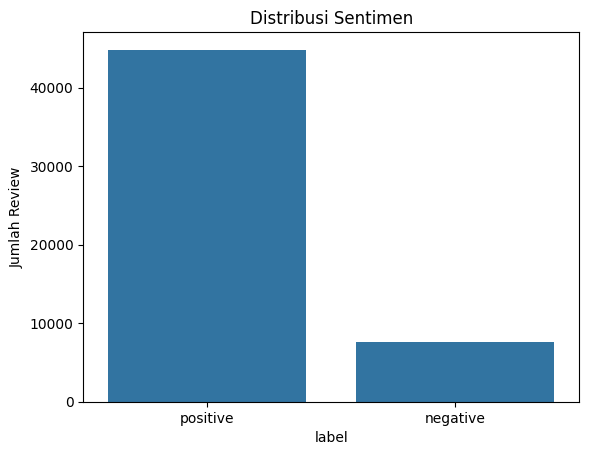

In [ ]:
# Visualisasi data pada label
sns.countplot(data=df_final, x="label", order=["positive", "negative"])
plt.title("Distribusi Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

In [ ]:
# Membuat tabel silang (Crosstab) antara Rating dan Label
# Ini akan menampilkan jumlah label (pos/neg) untuk setiap angka bintang (1-5)
distribusi_rating_label = pd.crosstab(df_final['Rating'], df_final['label'])

print("Distribusi Label Sentimen per Rating:")
print(distribusi_rating_label)

# Menghitung dalam bentuk persentase
persentase_distribusi = pd.crosstab(df_final['Rating'], df_final['label'], normalize='index') * 100
print("\nPersentase Label per Rating (%):")
print(persentase_distribusi.round(2))

Distribusi Label Sentimen per Rating:
label   negative  positive
Rating                    
1           2919      1116
2            725       501
3            917      3286
4           1046     11127
5           1993     28806

Persentase Label per Rating (%):
label   negative  positive
Rating                    
1          72.34     27.66
2          59.14     40.86
3          21.82     78.18
4           8.59     91.41
5           6.47     93.53


# 5. Split data

In [ ]:
# 1. Fitur & target
X = df_final["review_final"]
y = df_final["label"]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # penting karena imbalance
)

# 6. Model

## Model ML

In [ ]:
# 3. Selection fiture : TF-IDF (fit hanya di train) sebelum masuk pemodelan
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# Model logisticRegression
model_logisticRegression = LogisticRegression(max_iter=1000)
model_logisticRegression.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Model Multinomial Naive Bayes
model_naivebayes = MultinomialNB()
model_naivebayes.fit(X_train_tfidf, y_train)

MultinomialNB()

## MOdel DL

In [ ]:
df_for_deeplearning = df_final.copy()

In [ ]:
# encode label
le = LabelEncoder()
y_encoded = le.fit_transform(df_for_deeplearning["label"])
for i, label in enumerate(le.classes_):
    print(f"{i} -> {label}")

0 -> negative
1 -> positive


In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    df_for_deeplearning["review_final"],
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

### GlobalAveragePooling1D

In [ ]:
# tokenizer di train
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding="post")

In [ ]:
def build_fast_model(hp):
    model = Sequential()

    # 1. Perkecil dimensi embedding agar memori lebih hemat
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Int('embed_out', 32, 128, step=32),
        input_length=100
    ))

    # 2. GlobalAveragePooling1D
    model.add(GlobalAveragePooling1D())

    # 3. Tambahkan satu Dense layer opsional yang bisa di-tune
    model.add(Dense(
        units=hp.Int('dense_units', 16, 64, step=16),
        activation='relu'
    ))

    model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
    model.add(Dense(len(le.classes_), activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4])),
        metrics=["accuracy"]
    )
    return model

# Gunakan Hyperband: Lebih cerdas & cepat daripada RandomSearch
# karena bisa mematikan kombinasi yang jelek di awal (early stopping)
tuner = kt.Hyperband(
    build_fast_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='fast_tuning_dir',
    project_name='lgr_fast_sentiment'
)

# Gunakan batch_size yang lebih besar (misal 128 atau 256) agar GPU bekerja maksimal
tuner.search(X_train_pad, y_train, epochs=5, batch_size=256, validation_split=0.1)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.9194278717041016

Best val_accuracy So Far: 0.9234803318977356
Total elapsed time: 00h 04m 12s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Evaluasi

In [ ]:
# Evaluasi Logistic Regression
y_pred_model_logisticRegression = model_logisticRegression.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_model_logisticRegression))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1520
           1       0.96      0.98      0.97      8968

    accuracy                           0.95     10488
   macro avg       0.91      0.86      0.88     10488
weighted avg       0.94      0.95      0.94     10488



In [ ]:
# Evaluasi Naive Bayes
y_pred_model_naivebayes = model_naivebayes.predict(X_test_tfidf)
print("Naive Bayes")
print(classification_report(y_test, y_pred_model_naivebayes))

Naive Bayes
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1520
           1       0.96      0.98      0.97      8968

    accuracy                           0.94     10488
   macro avg       0.90      0.85      0.88     10488
weighted avg       0.94      0.94      0.94     10488



In [ ]:
# Evaluasi Global PoolingAverageID
loss, accuracy = best_model.evaluate(X_test_pad, y_test)
print(f"Akurasi Model Terbaik: {accuracy*100:.2f}%")


328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9129 - loss: 0.1786
Akurasi Model Terbaik: 91.43%


# Simpan Model Logistic Regression karena yang terbaik

In [ ]:
import joblib

# 1. Simpan Model Logistic Regression
joblib.dump(model_logisticRegression, 'model_sentiment_lgr.pkl')

# 2. Simpan TfidfVectorizer (Sangat Penting!)
joblib.dump(tfidf, 'tfidf_vectorizer_lgr.pkl')

# 3. Simpan LabelEncoder (Agar bisa mengembalikan angka ke teks)
joblib.dump(le, 'label_encoder_lgr.pkl')

print("Semua komponen berhasil disimpan!")

Semua komponen berhasil disimpan!


In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>